<a href="https://colab.research.google.com/github/eyaler/face_toolbox_keras/blob/master/Cloths_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [27]:
from pylab import imshow, show

In [3]:
import numpy as np

In [4]:
import cv2

In [5]:
import torch

In [6]:
import albumentations as albu

In [7]:
!pip install iglovikov_helper_functions

     |████████████████████████████████| 64 kB 1.5 MB/s 
     |████████████████████████████████| 2.1 MB 11.5 MB/s 


In [8]:
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image

In [9]:
!wget https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg > /dev/null

--2022-05-08 22:15:04--  https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg
Resolving habrastorage.org (habrastorage.org)... 82.192.95.170
Connecting to habrastorage.org (habrastorage.org)|82.192.95.170|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://hsto.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg [following]
--2022-05-08 22:15:05--  https://hsto.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg
Resolving hsto.org (hsto.org)... 172.67.71.175, 104.26.12.161, 104.26.13.161, ...
Connecting to hsto.org (hsto.org)|172.67.71.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55211 (54K) [image/jpeg]
Saving to: ‘eml7crxnxftrimsmolwjegqcrp4.jpeg’

eml7crxnxftrimsmolw 100%[===================>]  53.92K  --.-KB/s    in 0.001s  

2022-05-08 22:15:05 (69.5 MB/s) - ‘eml7crxnxftrimsmolwjegqcrp4.jpeg’ saved [55211/55211]



In [10]:
!pip install cloths_segmentation  > /dev/null

In [11]:
from cloths_segmentation.pre_trained_models import create_model

In [12]:
model = create_model("Unet_2020-10-30")

Downloading: "https://github.com/ternaus/cloths_segmentation/releases/download/0.0.1/weights.zip" to /root/.cache/torch/hub/checkpoints/weights.zip


  0%|          | 0.00/47.0M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/hub.py:518: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


In [13]:
model.eval();

In [14]:
image = load_rgb("eml7crxnxftrimsmolwjegqcrp4.jpeg")

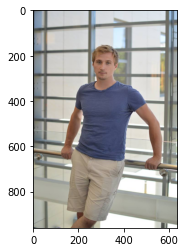

In [15]:
imshow(image)

In [16]:
transform = albu.Compose([albu.Normalize(p=1)], p=1)

In [17]:
padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)

In [18]:
x = transform(image=padded_image)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

In [19]:
with torch.no_grad():
  prediction = model(x)[0][0]

In [20]:
mask = (prediction > 0).cpu().numpy().astype(np.uint8)

In [21]:
mask = unpad(mask, pads)

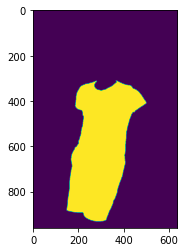

In [22]:
imshow(mask)

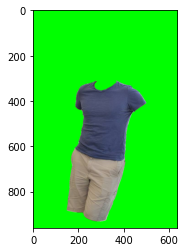

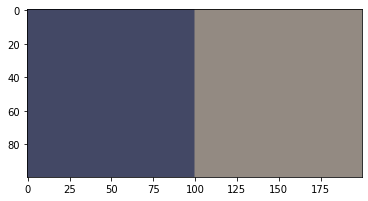

[((67, 72, 101), 73517, 0.565), ((147, 138, 130), 56250, 0.432)]


In [28]:
# Cloth colors:
from PIL import Image
num_colors =  3#@param {type: "integer"}
min_color_frac = 0.05 #@param {type: "slider", step:0.01, max:1}

skin = np.where(mask[..., None] > 0, image, (0,255,0)).astype(np.uint8)
imshow(skin)
show()

skin = Image.fromarray(skin)
colors = skin.quantize(colors=num_colors+1).convert('RGB').getcolors()
colors = sorted([color for color in colors if color[1] != (0,255,0)], reverse=True)
s = sum(color[0] for color in colors)
colors = [(color[1], color[0], round(color[0]/s, 3)) for color in colors if color[0] >= s*min_color_frac]
color_img = np.hstack([np.ones(shape=(100, 100, 3))*np.array(color[0]) for color in colors]).astype(np.uint8)
imshow(color_img)
show()

print(colors)


In [29]:
dst = cv2.addWeighted(image, 1, (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * (0, 255, 0)).astype(np.uint8), 0.5, 0)

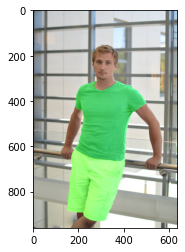

In [30]:
imshow(dst)

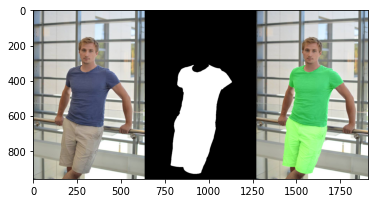

In [31]:
imshow(np.hstack([image, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255, dst]))